In [ ]:
import numpy as np
import pandas as pd
import scipy as scipy
from copy import deepcopy
import math
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from scipy.stats import t, chi2, f, norm, poisson, binom, uniform, expon, logistic
import seaborn as sns
import networkx as nx
import scipy.stats as stats

**Целевая переменная** - налоговые поступления правительства $\text{Taxes}_{i}$.

**Переменная воздействия** - уровень налоговой ставки $\text{Rate}_{i}$ (1 - высокая, 0 - низкая).

**Инструментальная переменная** - уровень неравенства в стране $\text{Inequality}_{i}$ (1 - высокое, 0 - низкое).

**Контрольные переменные**:

*   $\text{Deficit}_{i}$ - дефицит государственного бюджета в % от ВВП.
*   $\text{Progressive}_{i}$ - наличие прогрессивной шкалы налогообложения (1 - есть, 0 - нет).
*   $\text{Grey}_{i}$ - уровень теневой экономики в структуре экономики в %.

**Ненаблюдаемые переменные, порождающие эндогенность**:

*  $\text{Culture}_{i}$ - фискальная культура, склонность к уклонению от налогов.

## Генерация контрольных переменных

In [ ]:
np.random.seed(42)

In [ ]:
n = 100000

In [ ]:
#распределение дефицита государственного бюджета будет распределено согласно эмпирическим наблюдениям с сайта ОЭСР

In [ ]:
df = pd.read_excel('oecd.xsls.xlsx')
df = df.drop(index=[0, 1, 2]).reset_index(drop=True)
df.rename(columns={'Unnamed: 1': 'percentage'}, inplace=True)
df.rename(columns={'export-2025-02-24T15_40_02.795Z': 'country'}, inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: 'oecd.xsls.xlsx'

In [ ]:
df

,country,percentage
0,Norway,25.6486732221597
1,Denmark,3.44364102208029
2,Ireland,1.6501664110705
3,Switzerland,1.26682613130969
4,Chile,1.05504972262973
5,Sweden,1.00838656955393
6,Canada,0.555641297256343
7,Costa Rica,0.362242510385133
8,Israel,0.319256746382347
9,Luxembourg,0.192366727289143


In [ ]:
df['percentage'] = df['percentage'].astype(float)

In [ ]:
df.dtypes

,0
country,object
percentage,float64


In [ ]:
df['percentage'].mean()

-1.2618863541307674

In [ ]:
df['percentage'].std()

5.206197688291432

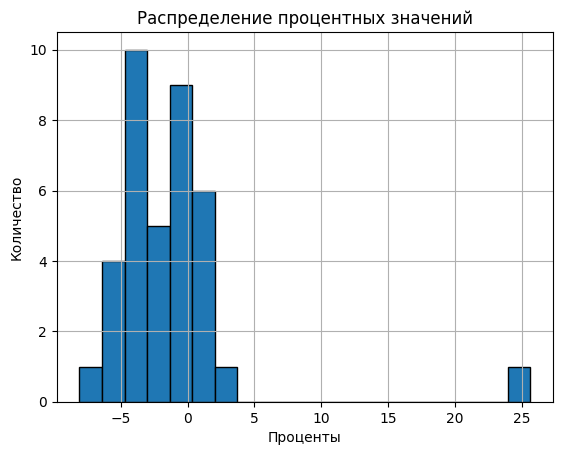

In [ ]:
df['percentage'].hist(bins=20, edgecolor='black')

plt.xlabel('Проценты')  # Подпись оси X
plt.ylabel('Количество')  # Подпись оси Y
plt.title('Распределение процентных значений')

image_path = "percentage_distribution.png"
plt.savefig(image_path, dpi=300, bbox_inches='tight')

plt.show()

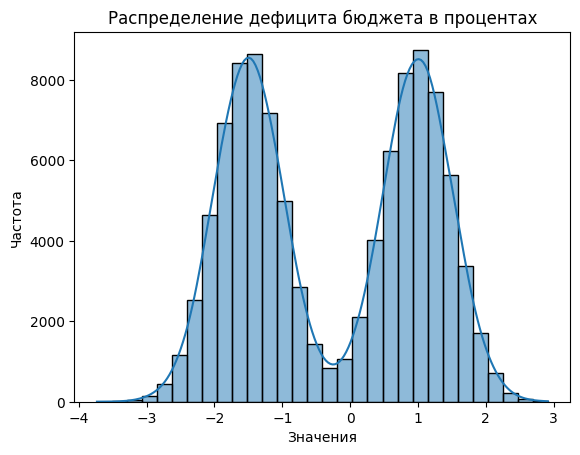

In [ ]:
mean1, std1, size1 = -1.5, 0.5, int(n/2)
mean2, std2, size2 = 1, 0.5, int(n/2 )

# Генерация данных
data1 = np.random.normal(mean1, std1, size1)
data2 = np.random.normal(mean2, std2, size2)
deficit = np.concatenate([data1, data2])

# Визуализация
sns.histplot(deficit, bins=30, kde=True)
plt.title('Распределение дефицита бюджета в процентах')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()


In [ ]:
#генерация данных по наличию прогрессивной шкалы налогообложения будет происходить при помощи нормальной копулы для прогрессивной шкалы налогообложения и для уровня фискальной культуры

In [ ]:
#генерация теневого уровня экономики. Будем считать, что в среднем в странах уровень теневой экономики составляет примерно 0,24 (24% от ВВП), со стандартным отклонением в 13%.

https://cyberleninka.ru/article/n/statisticheskie-izmereniya-tenevoy-ekonomiki/viewer

In [ ]:
#по данным из статьи видно, что данные хорошо ложатся на логнормальное распределение, поэтому по нему и будем моделировать данные в будущем

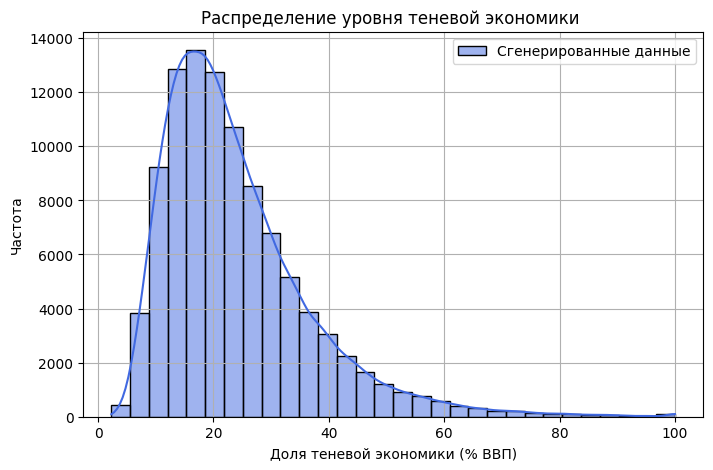

In [ ]:
mean_value = 24
std_dev = 13
mu = np.log(mean_value**2 / np.sqrt(std_dev**2 + mean_value**2))
sigma = np.sqrt(np.log(1 + (std_dev**2 / mean_value**2)))
grey = np.random.lognormal(mean=mu, sigma=sigma, size=n)
grey = np.clip(grey, None, 100)



plt.figure(figsize=(8, 5))
sns.histplot(grey, bins=30, kde=True, color="royalblue", label="Сгенерированные данные")
plt.xlabel("Доля теневой экономики (% ВВП)")
plt.ylabel("Частота")
plt.title("Распределение уровня теневой экономики ")
plt.legend()
plt.grid()

image_path = "ten_ek_distribution.png"
plt.savefig(image_path, dpi=300, bbox_inches='tight')

plt.show()

## Генерация ненаблюдаемой переменной

In [ ]:
#за ненаблюдаемую переменную мы взяли уровень фискальной культуры. Генерируем при помощи нормальной копулы, идею взяли тут https://habr.com/ru/articles/145751/

In [ ]:
import scipy.special as sp
z1 = np.random.normal(0, 1, n)
z2 = np.random.normal(0, 1, n)
rho = 0.25
matrix = np.linalg.cholesky([[1, rho], [rho, 1]]) #это разложение Холецкого, консультировались с chat gpt для написания этой части кода для копулы
z1_corr, z2_corr = matrix @ np.array([z1, z2])
progressive = (stats.norm.cdf(z1_corr) < 0.6).astype(int) #предполагаем, что вероятность прогрессивной шкалы в среднем в мире = 0.6

culture = sp.expit(z2_corr)
culture = 0.8 * culture + 0.2 * progressive
culture = (culture - np.min(culture)) / (np.max(culture) - np.min(culture))


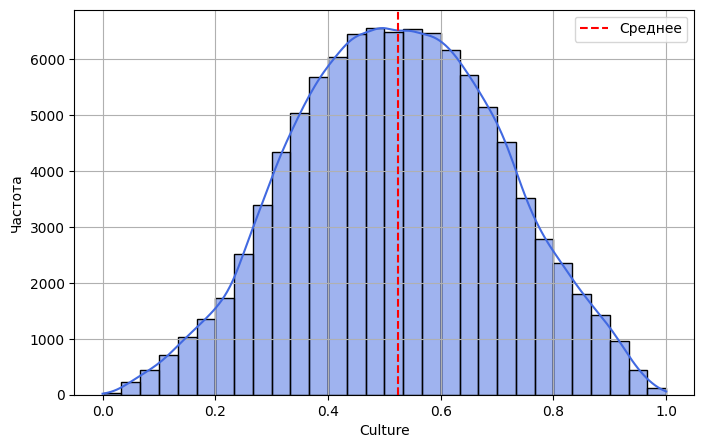

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(culture, bins=30, kde=True, color="royalblue", edgecolor="black")
plt.axvline(np.mean(culture), color='red', linestyle='dashed', label="Среднее")
plt.xlabel("Culture")
plt.ylabel("Частота")
plt.legend()
plt.grid(True)

image_path = "fis_cul_distribution.png"
plt.savefig(image_path, dpi=300, bbox_inches='tight')

plt.show()


## Генерация инструментальной переменной


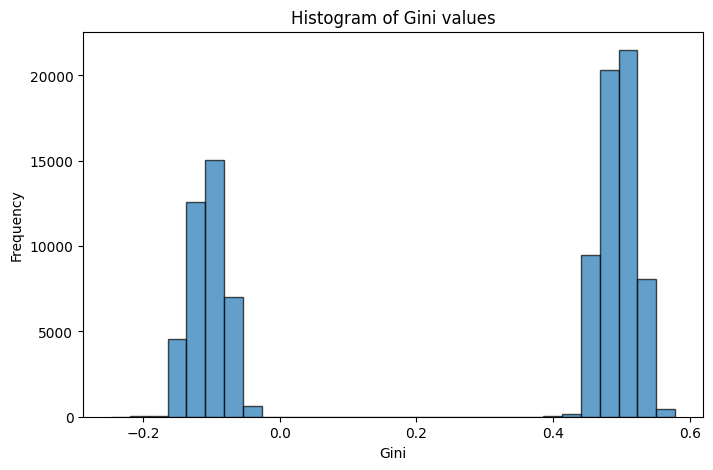

In [ ]:
alpha = 0.15  #это центр
beta1 = 0.5  #масштабирование сигмоиды
beta2 = 0.05  #перед дефицитом
beta3 = 0.6  #налог
gamma1 = 0.5  #регулируем силу эффектов

#тут внутри используем сигмоиду
gini_values = (alpha + beta1 * (1 / (1 + np.exp(-gamma1 * (deficit + grey)))) + \
             beta2 * np.log(1 + deficit**2) + \
             beta3 * progressive - 0.8)

plt.figure(figsize=(8, 5))
plt.hist(gini_values, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Gini values')
plt.xlabel('Gini')
plt.ylabel('Frequency')

image_path = "gini_distribution.png"
plt.savefig(image_path, dpi=300, bbox_inches='tight')

plt.show()

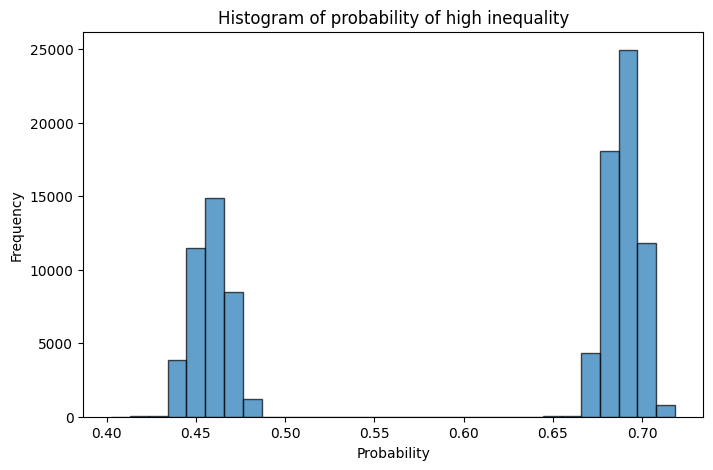

In [ ]:
gini_prob = norm.cdf(gini_values)

plt.figure(figsize=(8, 5))
plt.hist(gini_prob, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of probability of high inequality')
plt.xlabel('Probability')
plt.ylabel('Frequency')

image_path = "gini_prob_distribution.png"
plt.savefig(image_path, dpi=300, bbox_inches='tight')

plt.show()

Это отражает две группы стран: развитые и развивающиеся

In [ ]:
gini = np.random.binomial(n = 1, p = gini_prob, size = n)
print(gini[0:10])

[0 1 1 1 0 1 1 1 1 1]


## Генерация переменной воздействия

Здесь необходимо рассмотреть 2 сценария: когда в стране низкое неравенство и когда в стране высокое неравенство.



Условные вероятности переменной воздействия (налоговой ставки) зависят от контрольных переменных, инструментальной переменной (уровня неравенства) и ненаблюдаемой переменной (фискальной культуры):

$$
P(\text{Rate}_{i} = 1 | \text{Deficit}_{i}, \text{Progressive}_{i}, \text{Grey}_{i}, \text{Culture}_{i}, \text{Inequality}_{i}) =
F_{\text{Logistic}} \Big( 5 \times \ln(\text{Culture}_{i} + 1) + \sqrt{|\text{Deficit}_{i}|} + \text{Progressive}_{i} \times \text{Grey}_{i} - 20 + 4 \times \text{Inequality}_{i} \Big)
$$

где $F_{\text{Logistic}}$ — функция распределения стандартного логистического распределения.


Для краткости введем обозначение для условной вероятности высокой налоговой ставки при конкретном уровне неравенства:

$$
p_{k}^{\text{Inequality}_{i}} = P(\text{Rate}_{i} = 1 | \text{Deficit}_{i}, \text{Progressive}_{i}, \text{Grey}_{i}, \text{Culture}_{i}, \text{Inequality}_{i} = k), \quad k \in \{0,1\}
$$


Введем равномерную случайную величину $U_{i} \sim U(0,1)$ и определим гипотетические переменные:

$$
\text{Rate}_{1i} = I(p_{1}^{\text{Inequality}_{i}} \geq U_{i})
$$

$$
\text{Rate}_{0i} = I(p_{0}^{\text{Inequality}_{i}} \geq U_{i})
$$

где

$$
I(\text{условие}) =
\begin{cases}
1, & \text{если условие выполнено} \\
0, & \text{в противном случае}
\end{cases}
$$

Переменные $\text{Rate}_{1i}$ и $\text{Rate}_{0i}$ отражают потенциальный уровень налоговой ставки в зависимости от уровня неравенства в стране.


In [ ]:
u = uniform.rvs(size = n)

In [ ]:
rate_index = 5*(np.log(culture + 1)) + np.sqrt(abs(deficit)) + progressive * grey - 20

In [ ]:
gini_high = 1
rate_index_high = rate_index + 4*gini_high
rate_index_high = logistic.cdf(rate_index_high)
rates_high = (rate_index_high >= u).astype(int)

In [ ]:
np.mean(rates_high)

np.float64(0.50314)

In [ ]:
gini_low = 0
rate_index_low = rate_index + 4*gini_low
rate_index_low = logistic.cdf(rate_index_low)
rates_low = (rate_index_low >= u).astype(int)

In [ ]:
np.mean(rates_low)

np.float64(0.40845)

In [ ]:
cnt_type = np.empty(n, dtype = 'U25')
cnt_type[(rates_low == 1) & (rates_high == 1)] = 'Always taker'
cnt_type[(rates_high == 0) & (rates_low == 0)] = 'Never taker'
cnt_type[rates_high > rates_low]               = 'Complier'
cnt_type[rates_high < rates_low]               = 'Denier'


print(pd.value_counts(cnt_type))

Never taker     49686
Always taker    40845
Complier         9469
Name: count, dtype: int64


<ipython-input-21-1cf3bf25ecb3>:8: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(cnt_type))
<ipython-input-21-1cf3bf25ecb3>:8: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  print(pd.value_counts(cnt_type))


In [ ]:
print(pd.DataFrame(data    = np.array([rates_high, rates_low, cnt_type]).transpose(),
                   columns = ['rates_high', 'rates_low', 'Тип страны']))

      rates_high rates_low    Тип страны
0              0         0   Never taker
1              0         0   Never taker
2              1         1  Always taker
3              1         0      Complier
4              1         1  Always taker
...          ...       ...           ...
99995          1         0      Complier
99996          1         1  Always taker
99997          1         1  Always taker
99998          1         1  Always taker
99999          0         0   Never taker

[100000 rows x 3 columns]


In [ ]:
rates = rates_high * gini_prob + rates_low * (1 - gini_prob)

print(np.mean(rates))

0.47377908318508605


In [ ]:
print(pd.DataFrame(data    = [np.corrcoef(rates, culture)[0, 1],
                              np.corrcoef(rates, gini_prob)[0, 1]],
                   index   = ['Corr(rates, culture)',
                              'Corr(rates, gini_prob)'],
                   columns = ['Оценка']))

                          Оценка
Corr(rates, culture)    0.324825
Corr(rates, gini_prob)  0.809901


## Генерация целевой переменной


## Идея моделирования налоговых поступлений

Основная идея: **Эффект налоговой ставки** (`Rate_i`) зависит от уровня теневой экономики и фискальной культуры.

- При **низкой налоговой ставке** (`Rate_i = 0`) поступления зависят от **формальной экономики** и **фискальной дисциплины**.
- При **высокой налоговой ставке** (`Rate_i = 1`) возникает **неформальная адаптация** (уход в тень), но поступления могут компенсироваться прогрессивной шкалой и борьбой с уклонением.

### Уравнение налоговых поступлений при `Rate_i = 0` (низкая ставка)
$$
\text{Taxes}_{0i} = \underbrace{\underbrace{0.7 \times (1 - \text{Grey}_i)}_{g_{0}^{\text{obs}}} + \underbrace{15 \times \frac{10 - \text{Deficit}_i}{12 - \text{Inequality}_i + \text{Progressive}_i}}_{g_{0}^{\text{obs}}}}_{g_{0}} + \underbrace{0.2 \times (1 - \text{Culture}_i)}_{g_{0}^{\text{unobs}}} + \varepsilon_{0i}, \quad \varepsilon_{0i} \sim (5 \times t(10))
$$

- **Теневая экономика** (`Grey_i`) и **неравенство** (`Inequality_i`) оказывают влияние на налоговые поступления.
- **Культура** (`Culture_i`) является ненаблюдаемой переменной и оказывает значительное влияние на налоговые поступления.
- **Случайная ошибка** имеет распределение `t(10)`, моделируя редкие скачки.

### Уравнение налоговых поступлений при `Rate_i = 1` (высокая ставка)

$$
\text{Taxes}_{1i} = \underbrace{\underbrace{0.9 \times (1 - \text{Grey}_i)}_{g_{1}^{\text{obs}}} + \underbrace{17 \times \frac{10 - \text{Deficit}_i}{11 - \text{Inequality}_i + \text{Progressive}_i}}_{g_{1}^{\text{obs}}}}_{g_{1}} + \underbrace{0.2 \times (1 - \text{Culture}_i)}_{g_{1}^{\text{unobs}}} + \varepsilon_{1i}, \quad \varepsilon_{1i} \sim (\text{EXP}(0.08) - 8)
$$

- **Высокая ставка увеличивает влияние** `Culture_i` (фискальной культуры), поскольку уклонение от налогов становится более критичным.
- **Прогрессивная шкала** может частично компенсировать потери.
- **Ошибка** имеет экспоненциальное распределение (`EXP(0.08) - 8`), моделируя редкие резкие скачки налоговых поступлений.

### Наблюдаемые налоговые поступления

\[
\text{Taxes}_{i} = \begin{cases}
\text{Taxes}_{1i}, \quad \text{если } \text{Rate}_{i}=1 \\
\text{Taxes}_{0i}, \quad \text{если } \text{Rate}_{i}=0
\end{cases} = \text{Taxes}_{1i} \times \text{Rate}_{i} + \text{Taxes}_{0i} \times (1 - \text{Rate}_{i})
\]

### Интерпретация

- **Высокие налоги** могут снижать поступления за счет ухода в тень, но **при высокой фискальной культуре** это влияние уменьшается.
- **Контрольные переменные** помогают регулировать эффект (например, прогрессивная шкала смягчает потери).
- **Эндогенность** возникает из-за `Culture_i`, который влияет и на `Taxes_i`, и на `Rate_i`.




In [ ]:
rates

array([0., 0., 1., ..., 1., 1., 0.])

In [ ]:
grey

array([35.5933292 , 11.74457535, 28.25559004, ..., 22.88728637,
       32.57137355, 12.29568015])

In [ ]:
error0 = t.rvs(size=n, df=10) * 5  # случайная ошибка для низкой ставки
error1 = expon.rvs(size=n, scale=10) - 8  # случайная ошибка для высокой ставки
g0_obs = 15 * ((15 - (deficit))) / ((12 - gini_prob + progressive))
g0_unobs = 0.7 * (100 - grey)
g0 = g0_obs + g0_unobs

g1_obs = 17 * ((15 - (deficit))) / ((11 - gini_prob + progressive))
g1_unobs = 0.9 * (100 - grey) + 0.2 * (1 - culture)
g1 = g1_obs + g1_unobs

taxes0 = g0 + error0  # для низкой ставки
taxes1 = g1 + error1  # для высокой ставки

# Наблюдаемые налоговые поступления в зависимости от уровня налоговой ставки
rate = np.random.randint(0, 2, n)
taxes = taxes1 * rate + taxes0 * (1 - rate)

print(taxes[:10])

[ 93.15589213 111.28233228  85.58641281  75.9328393   74.00548698
  69.68405348  89.76130381 102.03935333  65.94762629  83.16360202]


## Описательные статистики

### Непрерывные переменые

In [ ]:
# deficit

mean = np.mean(deficit)
max = np.max(deficit)
min = np.min(deficit)
std = np.std(deficit)

print("Mean: ", mean)
print("Max: ", max)
print("Min: ", min)
print("Std: ", std)

Mean:  -0.2495165659295252
Max:  2.914891085670428
Min:  -3.7328019317644388
Std:  1.3471025901830815


In [ ]:
# grey
mean = np.mean(grey)
max = np.max(grey)
min = np.min(grey)
std = np.std(grey)

print("Mean: ", mean)
print("Max: ", max)
print("Min: ", min)
print("Std: ", std)


Mean:  23.986926972184573
Max:  100.0
Min:  2.2951414258356255
Std:  12.835148466010233


In [ ]:
# culture
mean = np.mean(culture)
max = np.max(culture)
min = np.min(culture)
std = np.std(culture)

print("Mean: ", mean)
print("Max: ", max)
print("Min: ", min)
print("Std: ", std)


Mean:  0.5235653758060572
Max:  1.0
Min:  0.0
Std:  0.18288365611848867


In [ ]:
# taxes
mean = np.mean(taxes)
max = np.max(taxes)
min = np.min(taxes)
std = np.std(taxes)

print("Mean: ", mean)
print("Max: ", max)
print("Min: ", min)
print("Std: ", std)


Mean:  83.1890025538597
Max:  216.8417751819184
Min:  4.48389944448682
Std:  17.148183091443244


### Бинарные переменные

In [ ]:
np.mean(progressive)

0.60046

In [ ]:
np.sum(progressive == 1)

60046

In [ ]:
np.mean(rate)

0.49939

In [ ]:
np.sum(rate == 1)

49939

In [ ]:
np.mean(gini)

0.5965

In [ ]:
df = pd.DataFrame({'taxes': taxes, 'rate': rate, 'deficit': deficit, 'grey': grey, 'inequality': gini, 'progressive': progressive, 'culture': culture})
df = df.loc[0:n, :]
df.head(10).style.format(precision = 2)

,taxes,rate,deficit,grey,inequality,progressive,culture
0,93.16,1,-1.25,35.59,0,0,0.21
1,111.28,1,-1.57,11.74,1,1,0.71
2,85.59,1,-1.18,28.26,1,1,0.51
3,75.93,0,-0.74,15.41,1,1,0.48
4,74.01,0,-1.62,17.87,0,1,0.74
5,69.68,0,-1.62,21.62,1,1,0.45
6,89.76,1,-0.71,19.86,1,0,0.52
7,102.04,1,-1.12,9.02,1,1,0.52
8,65.95,0,-1.73,42.53,1,1,0.66
9,83.16,1,-1.23,37.52,1,1,0.43


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

In [ ]:
print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")

Train size: (75000, 7), Test size: (25000, 7)


## Байесовская сеть

Дело в том, что оперативная память не выдерживает нагрузки загрузки данных, поэтому нам пришлось несколько обрезать данные, на которых будет обучаться модель

In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Классификация


В качестве признаков возьмем все сгенерированные данные

Рациональность использования этих признаком приведем ниже:
- Deficit - Дефицит государственного бюджета. Может влиять на налоговую ставку, так как при высоком дефиците государство может повышать налоги.
- Inequality - Уровень неравенства в стране. Может служить индикатором необходимости прогрессивного налогообложения, что может повлиять на налоговую ставку.
- Culture - Фискальная культура. Склонность к уклонению от налогов может влиять на решение правительства повышать или понижать ставки.
- Grey - Уровень теневой экономики. При высоком уровне теневой экономики государство может регулировать налоги для увеличения собираемости.
- Progressive - Наличие прогрессивной шкалы налогообложения. Если прогрессивное налогообложение уже действует, вероятность изменения налоговой ставки выше.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
X = df[['deficit', 'inequality', 'culture', 'grey', 'progressive']]
y = df['rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
models = {
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500)
}

results = []

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    cv_acc = np.mean(cross_val_score(model, X_train, y_train, cv=5))

    results.append([name, train_acc, test_acc, cv_acc])

df_results = pd.DataFrame(results, columns=["Model", "Train Accuracy", "Test Accuracy", "Cross-Validation Accuracy"])

df_results

,Model,Train Accuracy,Test Accuracy,Cross-Validation Accuracy
0,Naive Bayes,0.503080,0.50100,0.501160
1,KNN,0.688907,0.49928,0.501013
2,Random Forest,1.000000,0.49796,0.501280
3,Gradient Boosting,0.535013,0.50264,0.505133
4,Logistic Regression,0.503413,0.49756,0.500600


### Выводы

- Похоже, что метод Naive Bayes не находит значимых закономерностей, давая результаты, близкие к случайному угадыванию (около 50 процентом на каждом типе выборки). Таоке случается в ситуациях, когда признаки не соответствуют предположению о независимости (как в Наивном Байесовском классификаторе).
- Говоря о резульататх метода К билжайших соседий можно сказать, что модель переобучена – мы набдюдаем хорошие результаты на обучающих данных, но падение до случайного уровня на тестовых данных.
- Метод случацного леса: эта модель сильно переобучена – она идеально подстроилась под обучающие данные, но не умеет обобщать их на новые примеры. Мы еще не настроили параметры глубины и дерево по видимости получилось глубоким.
- Модель градиентного бустинга чуть лучше угадывает на тестовой выборке, но всё равно недостаточно эффективна. Возможно, количество деревьев слишком мало или есть проблема с важностью признаков.
- Финально, логистическая регрессия тоже не дает результатов выше случайного угадывания, что может означать, что данные плохо линейно разделимы.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Преобразуем y_train в числовые категории
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

param_grid = {
    "KNN": {"n_neighbors": [3, 5, 7, 9]},
    "Random Forest": {"n_estimators": [100, 200, 300], "max_depth": [None, 10, 20]},
    "Gradient Boosting": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1, 0.2]},
    "Logistic Regression": {"C": [0.1, 1, 10], "max_iter": [500, 1000]}
}

best_models = {}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid.get(name, {}), cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_

    print(f"Best params for {name}: {grid_search.best_params_}")

df_results = []
for name, model in best_models.items():
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    cv_acc = np.mean(cross_val_score(model, X_train, y_train, cv=5))

    df_results.append([name, train_acc, test_acc, cv_acc])

df_results = pd.DataFrame(df_results, columns=["Model", "Train Accuracy", "Test Accuracy", "Cross-Validation Accuracy"])
print(df_results)




Best params for Naive Bayes: {}
Best params for KNN: {'n_neighbors': 7}
Best params for Random Forest: {'max_depth': 10, 'n_estimators': 300}
Best params for Gradient Boosting: {'learning_rate': 0.1, 'n_estimators': 100}
Best params for Logistic Regression: {'C': 0.1, 'max_iter': 500}
                 Model  Train Accuracy  Test Accuracy  \
0          Naive Bayes        0.503080        0.50100   
1                  KNN        0.656307        0.49812   
2        Random Forest        0.651827        0.49868   
3    Gradient Boosting        0.535013        0.50264   
4  Logistic Regression        0.503373        0.49752   

   Cross-Validation Accuracy  
0                   0.501160  
1                   0.501253  
2                   0.503213  
3                   0.505133  
4                   0.500600  


In [ ]:
from itertools import product

params = {
    'max_depth': [3, 5, 10, 25, 50],
    'max_features': [1, 2, 3],
    'max_samples': [200, 500, 1000],
    'min_samples_leaf': [3, 5, 10, 25]
}
param_combinations = product(params['max_depth'], params['max_features'], params['max_samples'], params['min_samples_leaf'])

oob_scores = []
for q, w, e, r in param_combinations:
    rf_oob_i = RandomForestClassifier(
        max_depth=q,
        max_features=w,
        max_samples=e,
        min_samples_leaf=r,
        criterion='entropy',
        oob_score=True
    )
    rf_oob_i.fit(X_train, y_train)
    oob_scores.append([q, w, e, r, rf_oob_i.oob_score_])
oob_scores

In [ ]:
#с другой метрикой качества
from sklearn.metrics import f1_score, make_scorer, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score

# Используем F1-score в качестве критерия качества
scorer = make_scorer(f1_score, average="weighted")

best_models = {}  # Хранит лучшие модели

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid.get(name, {}), cv=5, scoring=scorer)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_

    print(f"Best params for {name}: {grid_search.best_params_}")

df_results = []  # Хранит метрики моделей

for name, model in best_models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")
    cv_f1 = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring=scorer))

    df_results.append([name, train_f1, test_f1, cv_f1])

    # Выводим confusion matrix для каждой модели
    print(f"\nConfusion Matrix for {name} (Test Data):")
    print(confusion_matrix(y_test, y_test_pred))

df_results = pd.DataFrame(df_results, columns=["Model", "Train F1", "Test F1", "Cross-Validation F1"])
print(df_results)



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

In [ ]:
#повышенная сложность
def custom_classification_metric(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")
    return (accuracy + precision + recall + f1) / 4

# Создаем метрику для GridSearchCV
custom_scorer = make_scorer(custom_classification_metric)

# Гиперпараметры для перебора
param_grid = {
    "DecisionTreeClassifier": {
        "max_depth": [3, 5, 10, 25, 50],
        "max_features": [1, 2, 3],
        "min_samples_leaf": [3, 5, 10, 25]
    },
    "RandomForestClassifier": {
        "max_depth": [3, 5, 10, 25, 50],
        "max_features": [1, 2, 3],
        "min_samples_leaf": [3, 5, 10, 25],
        "max_samples": [200, 500, 1000]
    }
}

# Модели
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

best_models = {}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid.get(name, {}), cv=5, scoring=custom_scorer)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best params for {name}: {grid_search.best_params_}")

# Оценка лучших моделей
df_results = []
for name, model in best_models.items():
    train_score = custom_classification_metric(y_train, model.predict(X_train))
    test_score = custom_classification_metric(y_test, model.predict(X_test))
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring=custom_scorer))

    df_results.append([name, train_score, test_score, cv_score])

df_results = pd.DataFrame(df_results, columns=["Model", "Train Score", "Test Score", "Cross-Validation Score"])
print(df_results)

Преимущества:
Учитывает баланс между Precision и Recall
Если в данных есть дисбаланс классов (например, один класс встречается гораздо чаще других), F1-score помогает лучше оценить модель, чем accuracy.
Более информативен в задачах с несбалансированными классами
Accuracy может быть обманчиво высокой, если модель просто предсказывает наиболее частый класс, тогда как F1-score штрафует за такие предсказания.
Лучше подходит для задач с важными ложными положительными (FP) и ложными отрицательными (FN) результатами
Например, в медицинской диагностике (где важны как FN, так и FP) F1-score помогает сбалансировать эти ошибки.
Недостатки:
Может быть сложнее интерпретировать
Accuracy дает интуитивно понятное представление о доле правильных предсказаний, тогда как F1-score комбинирует два метрики (Precision и Recall), что может быть менее очевидным для понимания.
Не отражает вероятность модели
Если модель хорошо прогнозирует с высокой уверенностью, но имеет небольшое число FP и FN, F1-score может быть не таким высоким, как хотелось бы, даже если модель все же полезна.
Не всегда предпочтительнее
Если классы сбалансированы и цель — просто максимизировать точность предсказаний, то accuracy может быть достаточной метрикой.

In [ ]:
#ROC-AUC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_predict

# Бинаризация меток классов (для многоклассового случая)
n_classes = len(np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))

plt.figure(figsize=(10, 7))

for name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)  # Используем вероятности классов
    else:
        y_score = cross_val_predict(model, X_test, y_test, cv=5, method="decision_function")

    if n_classes > 2:  # Многоклассовая классификация (One-vs-Rest)
        roc_auc = []
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            auc_score = auc(fpr, tpr)
            roc_auc.append(auc_score)
            plt.plot(fpr, tpr, lw=2, label=f"{name} (class {i}, AUC={auc_score:.3f})")

        mean_auc = np.mean(roc_auc)  # Средний AUC по классам
        print(f"{name}: Mean AUC = {mean_auc:.3f}")

    else:  # Бинарная классификация
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_score:.3f})")
        print(f"{name}: AUC = {auc_score:.3f}")

# Графические настройки
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Линия случайного угадывания
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая для моделей")
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Визуализируем предполагаемые связи

# Стиль отображения графика
nx_options = {
    'node_color': 'white',
    'node_size': 2000,
    'width': 3,
    'arrowstyle': '-|>',
    'arrowsize': 12,
}

# Связи
edges = [
    ('Deficit', 'Taxes'),         # (откуда стрелочка, куда стрелочка)
    ('Progressive', 'Taxes'),
    ('Grey', 'Taxes'),
    ('Rate', 'Taxes'),
    ('Culture', 'Taxes'),
    ('Culture', 'Rate'),
    ('Inequality', 'Rate'),

]

# Инициализируем граф
G = nx.DiGraph(directed = True)
G.add_edges_from(edges)

# Отображаем граф
np.random.seed(8)
nx.draw_networkx(G, arrows = True, **nx_options)

In [ ]:
pip install pgmpy

In [ ]:
X = df[['deficit', 'inequality', 'culture', 'grey', 'progressive']]
y = df['rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


## Регрессия

Таргет - налоговые поступления правительства

Возьмем все признаки, кроме переменной воздействия

Будем использовать случайный лес, МНК, градиентный бустинг.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
#отбрем признаки. туда войдет все, кроме переменной воздействия (по условию задания )

In [ ]:
df

In [ ]:
y = df['taxes']
X = df[['deficit', 'grey', 'inequality', 'progressive']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [ ]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
}

In [ ]:
#эта часть кода была оптимизирована при помощи chat gpt - в промпт передана была структура датафрейма и само задание
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    results = {
        'RMSE_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'MAPE_train': mean_absolute_percentage_error(y_train, y_train_pred),
        'MAPE_test': mean_absolute_percentage_error(y_test, y_test_pred)
    }
    return results


In [ ]:
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train, y_train, X_test, y_test)

In [ ]:
results_df = pd.DataFrame(results).T
print(results_df)

In [ ]:
def cross_val_rmse(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()

cv_results = {name: cross_val_rmse(model, X_train, y_train) for name, model in models.items()}
print("\nКросс-валидация RMSE:")
print(pd.Series(cv_results))

In [ ]:
#с подбором гиперпараметров
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 10],
    'max_depth': [3, 5, 3]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 10],
    'max_depth': [3, 5, 3],
    'learning_rate': [0.01, 0.1, 0.5]
}

rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

xgb_grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_xgb, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

best_params_rf = rf_grid_search.best_params_
optimized_rf = RandomForestRegressor(**best_params_rf, random_state=42)
optimized_rf.fit(X_train, y_train)

best_params_xgb = xgb_grid_search.best_params_
optimized_xgb = GradientBoostingRegressor(**best_params_xgb, random_state=42)
optimized_xgb.fit(X_train, y_train)


In [ ]:
rf_results_before = evaluate_model(models['RandomForest'], X_train, y_train, X_test, y_test)
rf_results_after = evaluate_model(optimized_rf, X_train, y_train, X_test, y_test)

xgb_results_before = evaluate_model(models['XGBoost'], X_train, y_train, X_test, y_test)
xgb_results_after = evaluate_model(optimized_xgb, X_train, y_train, X_test, y_test)

In [ ]:
final_comparison = pd.DataFrame({
    'Initial RandomForest': rf_results_before,
    'Tuned RandomForest': rf_results_after,
    'Initial XGBoost': xgb_results_before,
    'Tuned XGBoost': xgb_results_after
}).T

In [ ]:
final_comparison

In [ ]:
from sklearn.metrics import confusion_matrix

Предположим, что правительство государства хочет собрать налоговые поступления в зависимости от налоговой ставки (высокая/низкая).

1) Если мы как правительство установим высокую ставку и население не будет уклоняться от налогов (ТР), то мы получим полезность +10

2) Если мы как правительство установим высокую ставку и население будет уклоняться от налогов (FP), то мы получим ущерб -10, потому что это продолжает разрушать институциональную среду и не позволяет выработать хорошую налоговую систему

3) Если мы как правительство установим низкую ставку и население не будет уклоняться от налогов (FN), то мы получим полезность +1, потому что могли бы собрать больше

4) Если как правительство установим низкую ставку и население не будет уклоняться от налогов (ТN), то мы получим полезность +2, потому что соберем налоги и заложим хорошую институциональную базу

## Эффекты воздействия


21.747217255828673
23.346239186214614


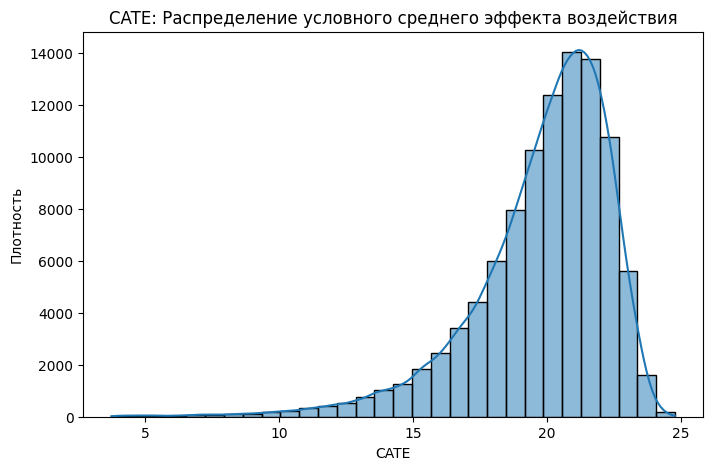

<Figure size 640x480 with 0 Axes>

In [ ]:
#ATE
TE = taxes1 - taxes0
ATE = np.mean(TE)
print(ATE)


#LATE
LATE = np.mean(TE[cnt_type == 'Complier'])
print(LATE)

#CATE
CATE = g1 - g0
plt.figure(figsize=(8,5))
sns.histplot(CATE, bins=30, kde=True)
plt.title('CATE: Распределение условного среднего эффекта воздействия')
plt.xlabel('CATE')
plt.ylabel('Плотность')
plt.show()
plt.savefig("CATE_plot.png", dpi=300, bbox_inches="tight")

In [ ]:
results_df = pd.DataFrame({'Метрика': ['ATE', 'LATE'], 'Значение': [ATE, LATE]})
print(results_df)

In [ ]:
ATE_naive = df[df['rate'] == 1]['taxes'].mean() - df[df['rate'] == 0]['taxes'].mean()
print(ATE_naive)

In [ ]:
import statsmodels.api as sm

In [ ]:
y0 = df.loc[rate == 0, ['taxes']]
x0 = df.loc[rate == 0, df.columns.drop(['taxes', 'culture', 'rate'])]
x0 = sm.add_constant(x0)
ls0 = sm.OLS(y0, x0).fit()

y1 = df.loc[rate == 1, ['taxes']]
x1 = df.loc[rate == 1, df.columns.drop(['taxes', 'culture', 'rate'])]
x1 = sm.add_constant(x1)
ls1 = sm.OLS(y1, x1).fit()

x = df.loc[:, df.columns.drop(['taxes', 'culture', 'rate'])]
x = sm.add_constant(x)
IMT0_ls = ls0.predict(x)
IMT1_ls = ls1.predict(x)

# Оценки CATE
CATE_ls = np.array(IMT1_ls - IMT0_ls)

# Оценка ATE как средняя разница в прогнозах МНК оценок
ATE_ls = np.mean(CATE_ls)
print(ATE_ls)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
y0 = df.loc[rate == 0, ['taxes']]
x0 = df.loc[rate == 0, df.columns.drop(['taxes', 'culture', 'rate'])]
x0 = sm.add_constant(x0)

y1 = df.loc[rate == 1, ['taxes']]
x1 = df.loc[rate == 1, df.columns.drop(['taxes', 'culture', 'rate'])]
x1 = sm.add_constant(x1)

x = df.loc[:, df.columns.drop(['taxes', 'culture', 'rate'])]
x = sm.add_constant(x)


reg3 = GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100})
reg3.fit(x0, y0)

taxes0_reg3 = reg3.predict(x)

reg3.fit(x1, y1)

taxes1_reg3 = reg3.predict(x)

CATE_T = taxes1_reg3 - taxes0_reg3

ATE_CM = np.mean(CATE_T)
print(ATE_CM)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
target = df.loc[:, ['rate']]
features = df.loc[:, df.columns.drop(['taxes', 'culture', 'rate'])]

clf =  RandomForestClassifier(max_depth = 5,
                                 max_features = 1,
                                 max_samples = 500,
                                 min_samples_leaf = 10,
                                 criterion = 'entropy',
                                 random_state = 42)
clf.fit(features, target)

prob_clf  = clf.predict_proba(features)[:, 1]

taxes_pseudo = (taxes * rate) / prob_clf  - (taxes * (1 - rate)) / (1 - prob_clf)

ATE_IPW = np.mean(taxes_pseudo)
print(ATE_IPW)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier

reg =  GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100})

y = df.loc[:, ['taxes']]
x = df.loc[:, df.columns.drop(['taxes', 'culture'])]
x0 = deepcopy(x)
x0['rate'] = 0
x1 = deepcopy(x)
x1['rate'] = 1


reg.fit(x, y)

taxes1_clf = reg.predict(x1)
taxes0_clf = reg.predict(x0)

ATE_DR = np.mean((taxes1_clf - taxes0_clf) + \
                 rate * (taxes -taxes1_clf) / prob_clf - \
                 (1 - rate) * (taxes - taxes0_clf) / (1 - prob_clf))
print(ATE_DR)

In [ ]:
pip install doubleml

In [ ]:
import doubleml as dml

dml_standard_data = dml.DoubleMLData(
                            data = df,
                            y_col = 'taxes',
                            d_cols = 'rate',
                            x_cols = ['deficit', 'progressive', 'grey'])

g_Y = GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100})

g_T = RandomForestClassifier(max_depth = 5,
                                 max_features = 1,
                                 max_samples = 500,
                                 min_samples_leaf = 10,
                                 criterion = 'entropy',
                                 random_state = 52)

dml_standard = dml.DoubleMLIRM(obj_dml_data = dml_standard_data,
                               ml_g = g_Y, ml_m = g_T,
                              #  apply_cross_fitting = True,
                               n_rep = 1,
                               n_folds = 5)

dml_standard.fit()

ATE_dml_standard = dml_standard.coef[0]
ATE_dml_standard

In [ ]:
dml_standard2_data = dml.DoubleMLData(
                             data = df,
                             y_col = 'taxes',
                             d_cols = 'rate',
                             x_cols = ['deficit', 'grey', 'progressive'])

dml_standard2 = dml.DoubleMLIRM(obj_dml_data = dml_standard2_data,
                                ml_g = g_Y, ml_m = g_T,
                                #apply_cross_fitting = True,
                                n_rep = 1,
                                n_folds = 5)

dml_standard2.fit()

LATE_dml_standard2 = dml_standard2.coef[0]
print(LATE_dml_standard2)

In [ ]:
df

In [ ]:
df

In [ ]:
dml_iv_data = dml.DoubleMLData(data = df,
                               y_col = 'taxes',
                               d_cols = 'rate',
                               z_cols = 'inequality',
                               x_cols =  ['deficit', 'grey', 'progressive'])

g_Z = RandomForestClassifier(max_depth = 5,
                                 max_features = 1,
                                 max_samples = 500,
                                 min_samples_leaf = 10,
                                 criterion = 'entropy',
                                 random_state = 52)

dml_iv = dml.DoubleMLIIVM(obj_dml_data = dml_iv_data,
                          ml_g = g_Y, ml_m = g_Z, ml_r = g_T,
                          #apply_cross_fitting = True,
                          n_rep = 1,
                          n_folds = 5)

dml_iv.fit()

LATE_dml_iv = dml_iv.coef[0]
print(LATE_dml_iv)

In [ ]:
y0 = df.loc[rate == 0, ['taxes']]
x0 = df.loc[rate == 0, df.columns.drop(['taxes', 'culture', 'rate'])]
x0 = sm.add_constant(x0)
ls0 = sm.OLS(y0, x0).fit()

y1 = df.loc[rate == 1, ['taxes']]
x1 = df.loc[rate == 1, df.columns.drop(['taxes', 'culture', 'rate'])]
x1 = sm.add_constant(x1)
ls1 = sm.OLS(y1, x1).fit()

x = df.loc[:, df.columns.drop(['taxes', 'culture', 'rate'])]
x = sm.add_constant(x)
taxes0_ls = ls0.predict(x)
taxes1_ls = ls1.predict(x)

CATE_ls = np.array(taxes1_ls - taxes0_ls)
print(CATE_ls)

In [ ]:
y = df.loc[:, ['taxes']]
x = df.loc[:, df.columns.drop(['taxes', 'culture'])]

reg2 = GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100})
reg2.fit(x, y)

x0 = deepcopy(x)
x0["rate"] = 0
taxes0_reg2  = reg2.predict(x0)

x1 = deepcopy(x)
x1["rate"] = 1
taxes1_reg2  = reg2.predict(x1)

CATE_S = taxes1_reg2  - taxes0_reg2
print(CATE_S)

In [ ]:
y0 = df.loc[rate == 0, ['taxes']]
x0 = df.loc[rate == 0, df.columns.drop(['taxes', 'culture', 'rate'])]
x0 = sm.add_constant(x0)

y1 = df.loc[rate == 1, ['taxes']]
x1 = df.loc[rate == 1, df.columns.drop(['taxes', 'culture', 'rate'])]
x1 = sm.add_constant(x1)

x = df.loc[:, df.columns.drop(['taxes', 'culture', 'rate'])]
x = sm.add_constant(x)


reg3 = GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100})

reg3.fit(x0, y0)

taxes0_reg3 = reg3.predict(x)

reg3.fit(x1, y1)

taxes1_reg3 = reg3.predict(x)

CATE_T = taxes1_reg3 - taxes0_reg3
print(CATE_T)

In [ ]:
reg4 = GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100})
reg4.fit(features, taxes_pseudo)

CATE_CT = reg4.predict(features)
print(CATE_CT)

In [ ]:
from sklearn.linear_model import LogisticRegression
y0 = df.loc[rate == 0, ['taxes']]
x0 = df.loc[rate == 0, df.columns.drop(['taxes', 'culture', 'rate'])]
x0 = sm.add_constant(x0)

y1 = df.loc[rate == 1, ['taxes']]
x1 = df.loc[rate == 1, df.columns.drop(['taxes', 'culture', 'rate'])]
x1 = sm.add_constant(x1)

y = df['taxes']
x = df.loc[:, df.columns.drop(['taxes', 'culture', 'rate'])]
x = sm.add_constant(x)

g = RandomForestClassifier(max_depth = 5,
                                 max_features = 1,
                                 max_samples = 500,
                                 min_samples_leaf = 10,
                                 criterion = 'entropy',
                                 random_state = 52)

m0 =  GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100})

m1 =  GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100})

m0.fit(x0, y0)
m1.fit(x1, y1)
g.fit(x, df['rate'])

d_train = np.where(df['rate']==0,
                   m1.predict(x) - y,
                   y - m0.predict(x))

mx0 = GradientBoostingRegressor(**{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50})
mx1 = GradientBoostingRegressor(**{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50})

mx0.fit(x0, d_train[df['rate']==0])
mx1.fit(x1, d_train[df['rate']==1])

def ps_predict(t):
    return g.predict_proba(x)[:, t]


x_cate = (ps_predict(1)*mx0.predict(x) +
                ps_predict(0)*mx1.predict(x))

print(x_cate)

In [ ]:
import numpy
import sklearn

print(numpy.__version__, sklearn.__version__)


In [ ]:

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
learner_r = BaseRRegressor(GradientBoostingRegressor(**{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}))
cate_r =  learner_r.fit_predict(X=df[['deficit', 'grey', 'progressive']], treatment=df['rate'], y=df['taxes'])

In [ ]:

cate_r

In [ ]:
CATE_MSE0 = pd.DataFrame(data    = [np.mean((CATE_ls[50000]  - CATE[50000]) ** 2),
                                    np.mean((CATE_T[50000]   - CATE[50000]) ** 2),
                                    np.mean((CATE_S[50000]   - CATE[50000]) ** 2),
                                    np.mean((CATE_CT[50000]  - CATE[50000]) ** 2),
                                    np.mean((x_cate[50000] - CATE[50000]) ** 2),
                                    np.mean((cate_r[50000] - CATE[50000]) ** 2)],
                   index          = ['LS', 'T-learner', 'S-learner', 'CT', 'X-learner', 'R-learner'],
                   columns        = ['MSE0'])
print(CATE_MSE0)

In [ ]:
CATE_MSE1 = pd.DataFrame(data    = [np.mean((taxes_pseudo[5000]  - CATE_ls[5000] ) ** 2),
                                    np.mean((taxes_pseudo[5000]  - CATE_T[5000] ) ** 2),
                                    np.mean((taxes_pseudo[5000]  - CATE_S[5000] ) ** 2),
                                    np.mean((taxes_pseudo[5000] - CATE_CT[5000] ) ** 2),
                                    np.mean((taxes_pseudo[50000] - x_cate[50000]) ** 2),
                                    np.mean((taxes_pseudo[5000]  - cate_r[5000] ) ** 2)],
                   index          = ['LS', 'T-learner', 'S-learner', 'CT', 'X-learner', 'R - learner'],
                   columns        = ['MSE1'])
print(CATE_MSE1)

In [ ]:
y0 = df.loc[rate == 0, ['taxes']]
x0 = df.loc[rate == 0, df.columns.drop(['taxes', 'culture', 'rate'])]
x0 = sm.add_constant(x0)
ls0 = sm.OLS(y0, x0).fit()

y1 = df.loc[rate == 1, ['taxes']]
x1 = df.loc[rate == 1, df.columns.drop(['taxes', 'culture', 'rate'])]
x1 = sm.add_constant(x1)
ls1 = sm.OLS(y1, x1).fit()

x = df.loc[:, df.columns.drop(['taxes', 'culture', 'rate'])]
x = sm.add_constant(x)
taxes0_ls = ls0.predict(x)
taxes1_ls = ls1.predict(x)


CATE_ls = np.array(taxes1_ls - taxes0_ls)
ATE_ls = np.mean(CATE_ls)
print(ATE_ls)

In [ ]:
y0 = df.loc[rate == 0, ['taxes']]
x0 = df.loc[rate == 0, df.columns.drop(['taxes', 'culture', 'rate'])]
x0 = sm.add_constant(x0)

y1 = df.loc[rate == 1, ['taxes']]
x1 = df.loc[rate == 1, df.columns.drop(['taxes', 'culture', 'rate'])]
x1 = sm.add_constant(x1)

x = df.loc[:, df.columns.drop(['taxes', 'culture', 'rate'])]
x = sm.add_constant(x)


reg3 = GradientBoostingRegressor(**{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50})
reg3.fit(x0, y0)

taxes0_reg3 = reg3.predict(x)

reg3.fit(x1, y1)

taxes1_reg3 = reg3.predict(x)

CATE_T = taxes1_reg3 - taxes0_reg3

ATE_CM = np.mean(CATE_T)
print(ATE_CM)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
target = df.loc[:, ['rate']]
features = df.loc[:, df.columns.drop(['taxes', 'culture', 'rate'])]

clf =  LogisticRegression(penalty = 'l1',
                             solver = 'liblinear',
                             max_iter = 200,
                             fit_intercept = True)
clf .fit(features, target)

prob_clf  = clf .predict_proba(features)[:, 1]

taxes_pseudo = (taxes * rate) / prob_clf  - (taxes * (1 - rate)) / (1 - prob_clf)

ATE_IPW_2 = np.mean(taxes_pseudo)
print(ATE_IPW_2)

In [ ]:

x = df.loc[:, df.columns.drop(['taxes', 'rate'])].copy()
x['rate'] = df['rate']

y = df[['taxes']]

reg = LinearRegression()
reg.fit(x, y)
x0 = x.copy()
x0['rate'] = 0

x1 = x.copy()
x1['rate'] = 1

taxes1_clf = reg.predict(x1)[:1000]
taxes0_clf = reg.predict(x0)[:1000]


ATE_DR_2 = np.mean(
    (taxes1_clf - taxes0_clf)
    + rate[:1000] * (taxes[:1000] - taxes1_clf) / prob_clf[:1000]
    - (1 - rate[:1000]) * (taxes[:1000] - taxes0_clf) / (1 - prob_clf[:1000])
)
print(ATE_DR_2)


In [ ]:
dml_standard_data = dml.DoubleMLData(
                            data = df,
                            y_col = 'taxes',
                            d_cols = 'rate',
                            x_cols = ['deficit', 'grey', 'progressive'])

g_Y = LinearRegression()

g_T = KNeighborsClassifier(n_neighbors = 100,
                            metric = "minkowski",
                            p = 3,
                            weights = 'uniform')

dml_standard = dml.DoubleMLIRM(obj_dml_data = dml_standard_data,
                               ml_g = g_Y, ml_m = g_T,
                              #  apply_cross_fitting = True,
                               n_rep = 1,
                               n_folds = 5)

dml_standard.fit()

ATE_dml_standard_2 = dml_standard.coef[0]
print(ATE_dml_standard_2)

In [ ]:
dml_standard2_data = dml.DoubleMLData(
                             data = df,
                             y_col = 'taxes',
                             d_cols = 'rate',
                             x_cols = ['deficit', 'grey', 'progressive'])

dml_standard2 = dml.DoubleMLIRM(obj_dml_data = dml_standard2_data,
                                ml_g = g_Y, ml_m = g_T,
                                #apply_cross_fitting = True,
                                n_rep = 1,
                                n_folds = 5)

dml_standard2.fit()

LATE_dml_standard2_2 = dml_standard2.coef[0]
print(LATE_dml_standard2_2)

In [ ]:
print(df['culture'].value_counts())

In [ ]:
small_df = df.sample(frac=0.05, random_state=42)  #неудавшийся байес

train_data, test_data = train_test_split(small_df, test_size=0.2, random_state=42)

edges = [
    ('deficit', 'taxes'),
    ('progressive', 'taxes'),
    ('grey', 'taxes'),
    ('rate', 'taxes'),
    ('culture', 'taxes'),
    ('culture', 'rate'),
    ('inequality', 'rate'),
]

bayes_net = BayesianNetwork(edges)
bayes_net.fit(train_data, estimator=MaximumLikelihoodEstimator)
inference = VariableElimination(bayes_net)
test_sample = test_data.sample(100, random_state=42)

predictions = bayes_net.predict(test_sample.drop(columns=['Taxes']))
accuracy = accuracy_score(test_sample['Taxes'], predictions)
print(f'Accuracy of Bayesian Network on smaller dataset: {accuracy:.2f}')